In [1]:
!pip install transformers
!pip install torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [2]:
from torchtext.data import Field, TabularDataset, BucketIterator,LabelField
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [3]:
print(torch.version.cuda)
print(torch.__version__)
import sys
print(sys.version)
print(np.__version__)
print(pd.__version__)


11.8
2.0.1+cu118
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
1.23.5
1.5.3


In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)


init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

[CLS] [SEP] [PAD] [UNK]
101 102 0 100
101 102 0 100


In [6]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

512


In [7]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    padding_length = max_input_length - len(tokens) - 2
    tokens = tokens + [pad_token] * padding_length
    return tokens



In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the original dataset
df = pd.read_csv('missom_annotated.csv')
df = df.drop(columns=['post_id','how_annotated'])

empty_cells =  df.isnull().sum()
print(empty_cells)
df.dropna(inplace = True)



text                      0
label_minority_coping     0
label_prej_event          0
label_exp_reject          0
label_identity_conceal    0
label_internal_stigma     0
label_dysphoria           0
label_minority_stress     0
dtype: int64


In [9]:
from sklearn.model_selection import train_test_split
train_ratio = 0.70
valid_ratio = 0.15
test_ratio = 0.15
train_df, remaining_df = train_test_split(df, test_size=1 - train_ratio, random_state=random.seed(SEED))
valid_df, test_df = train_test_split(remaining_df, test_size=test_ratio/(valid_ratio + test_ratio), random_state=random.seed(SEED))
# Save the dataframes to CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

In [10]:
TEXT = Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = LabelField(dtype = torch.float)

In [11]:
# Labels in the dataset
label_fields = [
    'label_minority_coping',
    'label_prej_event',
    'label_exp_reject',
    'label_identity_conceal',
    'label_internal_stigma',
    'label_dysphoria',
    'label_minority_stress'
]

# Create label fields for each label in multi-label classification
label_fields_objs = [LabelField(dtype=torch.float) for _ in label_fields]


In [12]:
# Load the data
train_data, valid_data, test_data = TabularDataset.splits(
    path='/content/',
    train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv',
    fields=[('text', TEXT)] + [(label, label_field) for label, label_field in zip(label_fields, label_fields_objs)],
    skip_header=True

)
print('Number of training examples: {}'.format(len(train_data)))
print('Number of Validation examples: {}'.format(len(valid_data)))
print('Number of testing examples: {}'.format(len(test_data)))
print(train_data[0])

Number of training examples: 4052
Number of Validation examples: 868
Number of testing examples: 869


In [13]:
TEXT.build_vocab(train_data, min_freq=1)
# Build vocab for label fields
for label_field in label_fields_objs:
    label_field.build_vocab(train_data)

In [14]:
BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True
    )

In [15]:
from transformers import BertTokenizer, BertModel
bert = BertModel.from_pretrained('bert-base-uncased')

In [16]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self,bert, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.fc(cat)

In [17]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = len(label_fields) #1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(bert,INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model = model.to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 120,063,847 trainable parameters


In [19]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [20]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [21]:
def multi_label_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / (len(label_fields) * len(correct))
    return acc

In [22]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text = batch.text
        predictions = model(text)

        sigmoid_preds = torch.sigmoid(predictions)
        for i, label_field in enumerate(label_fields_objs):
                label_name = label_fields[i]
                output_1 = (sigmoid_preds[:, i] > 0.5).int()
                loss = criterion(predictions[:, i], getattr(batch, label_name))
                acc = multi_label_accuracy(predictions[:, i], getattr(batch, label_name))
                loss.backward(retain_graph=True)
                optimizer.step()
                epoch_loss += loss.item()
                epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            predictions = model(text)
            sigmoid_preds = torch.sigmoid(predictions)
            for i, label_field in enumerate(label_fields_objs):
                label_name = label_fields[i]
                output_1 = (sigmoid_preds[:, i] > 0.5).int()
                loss = criterion(predictions[:, i], getattr(batch, label_name))
                acc = multi_label_accuracy(predictions[:, i], getattr(batch, label_name))
                epoch_loss += loss.item()
                epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 33s
	Train Loss: 2.737 | Train Acc: 88.45%
	 Val. Loss: 2.021 |  Val. Acc: 89.57%
Epoch: 02 | Epoch Time: 3m 31s
	Train Loss: 2.147 | Train Acc: 89.52%
	 Val. Loss: 1.982 |  Val. Acc: 89.67%
Epoch: 03 | Epoch Time: 3m 31s
	Train Loss: 2.140 | Train Acc: 89.72%
	 Val. Loss: 2.017 |  Val. Acc: 89.49%
Epoch: 04 | Epoch Time: 3m 31s
	Train Loss: 2.042 | Train Acc: 89.94%
	 Val. Loss: 2.027 |  Val. Acc: 89.56%
Epoch: 05 | Epoch Time: 3m 31s
	Train Loss: 1.959 | Train Acc: 90.06%
	 Val. Loss: 1.885 |  Val. Acc: 89.78%
Epoch: 06 | Epoch Time: 3m 31s
	Train Loss: 1.933 | Train Acc: 90.09%
	 Val. Loss: 1.826 |  Val. Acc: 89.96%
Epoch: 07 | Epoch Time: 3m 31s
	Train Loss: 1.943 | Train Acc: 90.09%
	 Val. Loss: 1.921 |  Val. Acc: 89.86%
Epoch: 08 | Epoch Time: 3m 31s
	Train Loss: 1.895 | Train Acc: 90.00%
	 Val. Loss: 1.894 |  Val. Acc: 89.84%
Epoch: 09 | Epoch Time: 3m 31s
	Train Loss: 1.849 | Train Acc: 90.28%
	 Val. Loss: 1.874 |  Val. Acc: 89.67%
Epoch: 10 | Epoch T

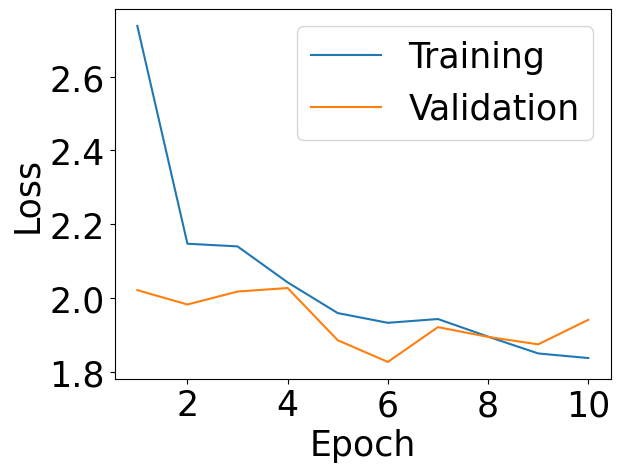

In [25]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_losses, label='Training')
plt.plot(epochs, valid_losses, label='Validation')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss', fontsize=25)

# Increase the font size of x and y tick labels
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(fontsize=25)
plt.show()

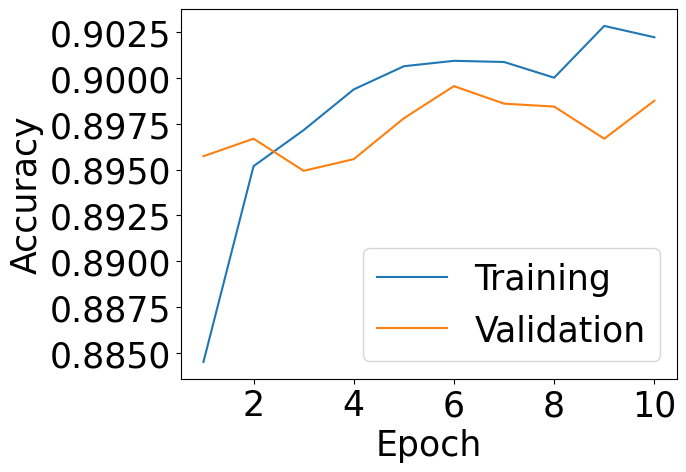

In [26]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_accuracies, label='Training')
plt.plot(epochs, valid_accuracies, label='Validation')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

def calc_report(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    y_pred = [[] for _ in range(len(label_fields))]
    y_true = [[] for _ in range(len(label_fields))]
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            predictions = model(text)
            sigmoid_preds = torch.sigmoid(predictions)
            for i, label_field in enumerate(label_fields_objs):
                label_name = label_fields[i]
                output_1 = (sigmoid_preds[:, i] > 0.5).int()
                y_pred[i].extend(output_1.tolist())
                y_true[i].extend(getattr(batch, label_name).tolist())
                loss = criterion(predictions[:, i], getattr(batch, label_name))
                acc = multi_label_accuracy(predictions[:, i], getattr(batch, label_name))
                epoch_loss += loss.item()
                epoch_acc += acc.item()
        all_reports = []
        for i, label_field in enumerate(label_fields_objs):
            rep = classification_report(y_true[i], y_pred[i], labels=[1, 0], digits=2)
            print('_________'*8)
            print(label_fields[i])
            print(rep)







In [28]:
calc_report(model, test_iterator, criterion)


________________________________________________________________________
label_minority_coping
              precision    recall  f1-score   support

           1       0.42      0.15      0.22       112
           0       0.89      0.97      0.93       757

    accuracy                           0.86       869
   macro avg       0.66      0.56      0.57       869
weighted avg       0.83      0.86      0.84       869

________________________________________________________________________
label_prej_event
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        74
           0       0.91      1.00      0.96       795

    accuracy                           0.91       869
   macro avg       0.46      0.50      0.48       869
weighted avg       0.84      0.91      0.87       869

________________________________________________________________________
label_exp_reject
              precision    recall  f1-score   support

           1    

Reference for this code is below to this link.


https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb